# Module 19 - Final Challenge

1. Load the houseprices data from Thinkful's database.
2. Do data cleaning, exploratory data analysis, and feature engineering. You can use your previous work in this module. But make sure that your work is satisfactory.
3. Now, split your data into train and test sets where 20% of the data resides in the test set.
4. Build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one!
5. Evaluate your best model on the test set.  
6. So far, you have only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.

In [1]:
# import libraries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
import sklearn
import statsmodels.api as sm

from sklearn import linear_model
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from statsmodels.tsa.stattools import acf
from statsmodels.tools.eval_measures import mse, rmse

#from sklearn.naive_bayes import BernoulliNB
#from sklearn import tree
#from IPython.display import Image
#import pydotplus

In [2]:
# import dataset
df = pd.read_csv(r'C:\Users\AP\Downloads\house prices.csv')

# ----- DATA CLEAN CONDENSED FROM PREVIOUS WORK ON SAME DATASET -----

# convert columns to lower case
df.columns = map(str.lower, df.columns)

# create numerical column variable
num_col = df.select_dtypes(['int64', 'float64']).columns

# create alpha column variable
alpha_col = df.select_dtypes(['object']).columns

# convert alpha columns to binary
df['mszoning'] = pd.get_dummies(df.mszoning, drop_first=True)
df['neighborhood'] = pd.get_dummies(df.neighborhood, drop_first=True)
df['exterior1st'] = pd.get_dummies(df.exterior1st, drop_first=True)

# create interaction variable between basement, first, and second floor sq ft
df['totalsf'] = df.totalbsmtsf + df['1stflrsf'] + df['2ndflrsf']

# create interaction variable between total sq ft and overall quality
df['int_over_sf'] = df.totalsf * df.overallqual

alphas = [100,1]

# Exploratory Data Analysis

In [3]:
# basic size and shape of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 83 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null uint8
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null uint8
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-nul

#### Observations  
- The dataset contains 83 columns and 1460 rows

In [4]:
# sample view of dataset
df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice,totalsf,int_over_sf
0,1,60,0,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,2,2008,WD,Normal,208500,2566,17962
1,2,20,0,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,5,2007,WD,Normal,181500,2524,15144
2,3,60,0,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,0,9,2008,WD,Normal,223500,2706,18942
3,4,70,0,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,0,2,2006,WD,Abnorml,140000,2473,17311
4,5,60,0,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,0,12,2008,WD,Normal,250000,3343,26744


In [5]:
# quantify missing data
total_missing = df.isnull().sum().sort_values(ascending=False)
percent_missing = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Count', 'Percent'])

missing_data.head()

,Count,Percent
poolqc,1453,0.995205
miscfeature,1406,0.963014
alley,1369,0.937671
fence,1179,0.807534
fireplacequ,690,0.472603
lotfrontage,259,0.177397
garagequal,81,0.055479
garagecond,81,0.055479
garagetype,81,0.055479
garageyrblt,81,0.055479


#### Observations  
- There are six variables with significant missing data ranging from approximately 18-99%. However, these variables do not strike me as overly important. We will leave them for now and most likely not use those variables at all. If it turns out these variables should be included in the models, outliers should be addressed.

In [6]:
# define numerical variables

# define alpha variables
alpha_col = df.select_dtypes(['object']).columns

# print list/count numerical variables
print('Numerical Variables: ')
print('')
print(num_col)
print("Count: {}".format(len(num_col)))

print('')
print('')

# print list/count alpha variables
print('Alpha Variables: ')
print('')
print(alpha_col)
print("Count: {}".format(len(alpha_col)))

Numerical Variables: 

Index(['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', '1stflrsf', '2ndflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd',
       'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
       'openporchsf', 'enclosedporch', '3ssnporch', 'screenporch', 'poolarea',
       'miscval', 'mosold', 'yrsold', 'saleprice'],
      dtype='object')
Count: 38


Alpha Variables: 

Index(['street', 'alley', 'lotshape', 'landcontour', 'utilities', 'lotconfig',
       'landslope', 'condition1', 'condition2', 'bldgtype', 'housestyle',
       'roofstyle', 'roofmatl', 'exterior2nd', 'masvnrtype', 'exterqual',
       'extercond', 'foundation', 'bsmtqual', 'bsmtcond', 'bsmtexposure',
       'bsmtfintype1', 'bsmtfintype2', 'heating

#### Observations  
- There are 40 numerical variables and 40 alpha variables
- The alpha variables will need to be converted to dummy binaries or one hot encoding

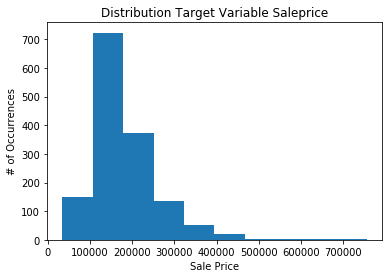

Sale Price JB test stat: 3438.8721241220583 /// p value: 0.0


In [7]:
# distribution of target variable
plt.hist(df.saleprice)
plt.title('Distribution Target Variable Saleprice')
plt.xlabel('Sale Price')
plt.ylabel('# of Occurrences')

plt.show()

# JB test to check for normality
from scipy.stats import jarque_bera

jb_stats = jarque_bera(df.saleprice)

# print results
print('Sale Price JB test stat: {0} /// p value: {1}'.format(jb_stats[0], jb_stats[1]))

#### Observations  
- The distribution appears relatively normal and the p-value of the JB test is zero, confirming normality

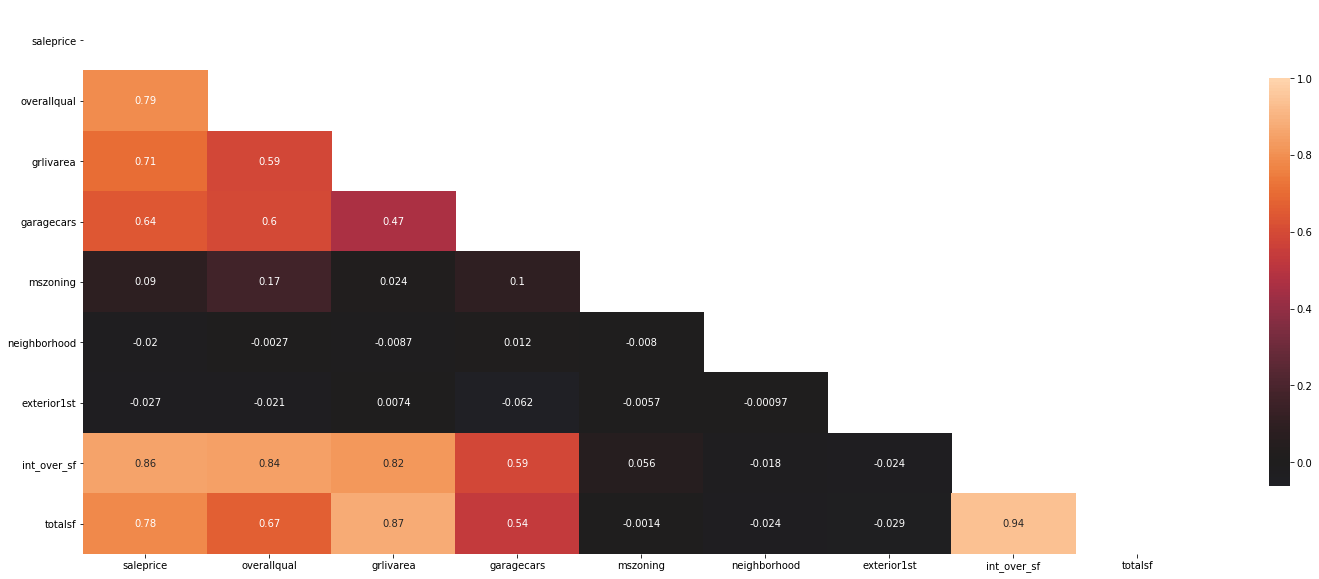

In [8]:
# correlation matric key variables

# key variables correlation
corr = df[['saleprice',
           'overallqual', 
           'grlivarea', 
           'garagecars', 
           'mszoning', 
           'neighborhood', 
           'exterior1st', 
           'int_over_sf', 
           'totalsf'
           ]].corr()

# generate mask for upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# plot heatmap correlation
plt.figure(figsize=(25,10))
sns.heatmap(corr, mask=mask, annot=True, cbar_kws={"shrink": .75}, center=0)

plt.show()

#### Observations  
- There are five variables that appear to be highly correlated with the target saleprice
- The remaining three variables mszoning, neighborhood, and exterior1st have correlation scores of approximately zero
- There are quite a few variables that are correlated with each other as well
- We will try different variations of the final feature set to see if how they affect the models

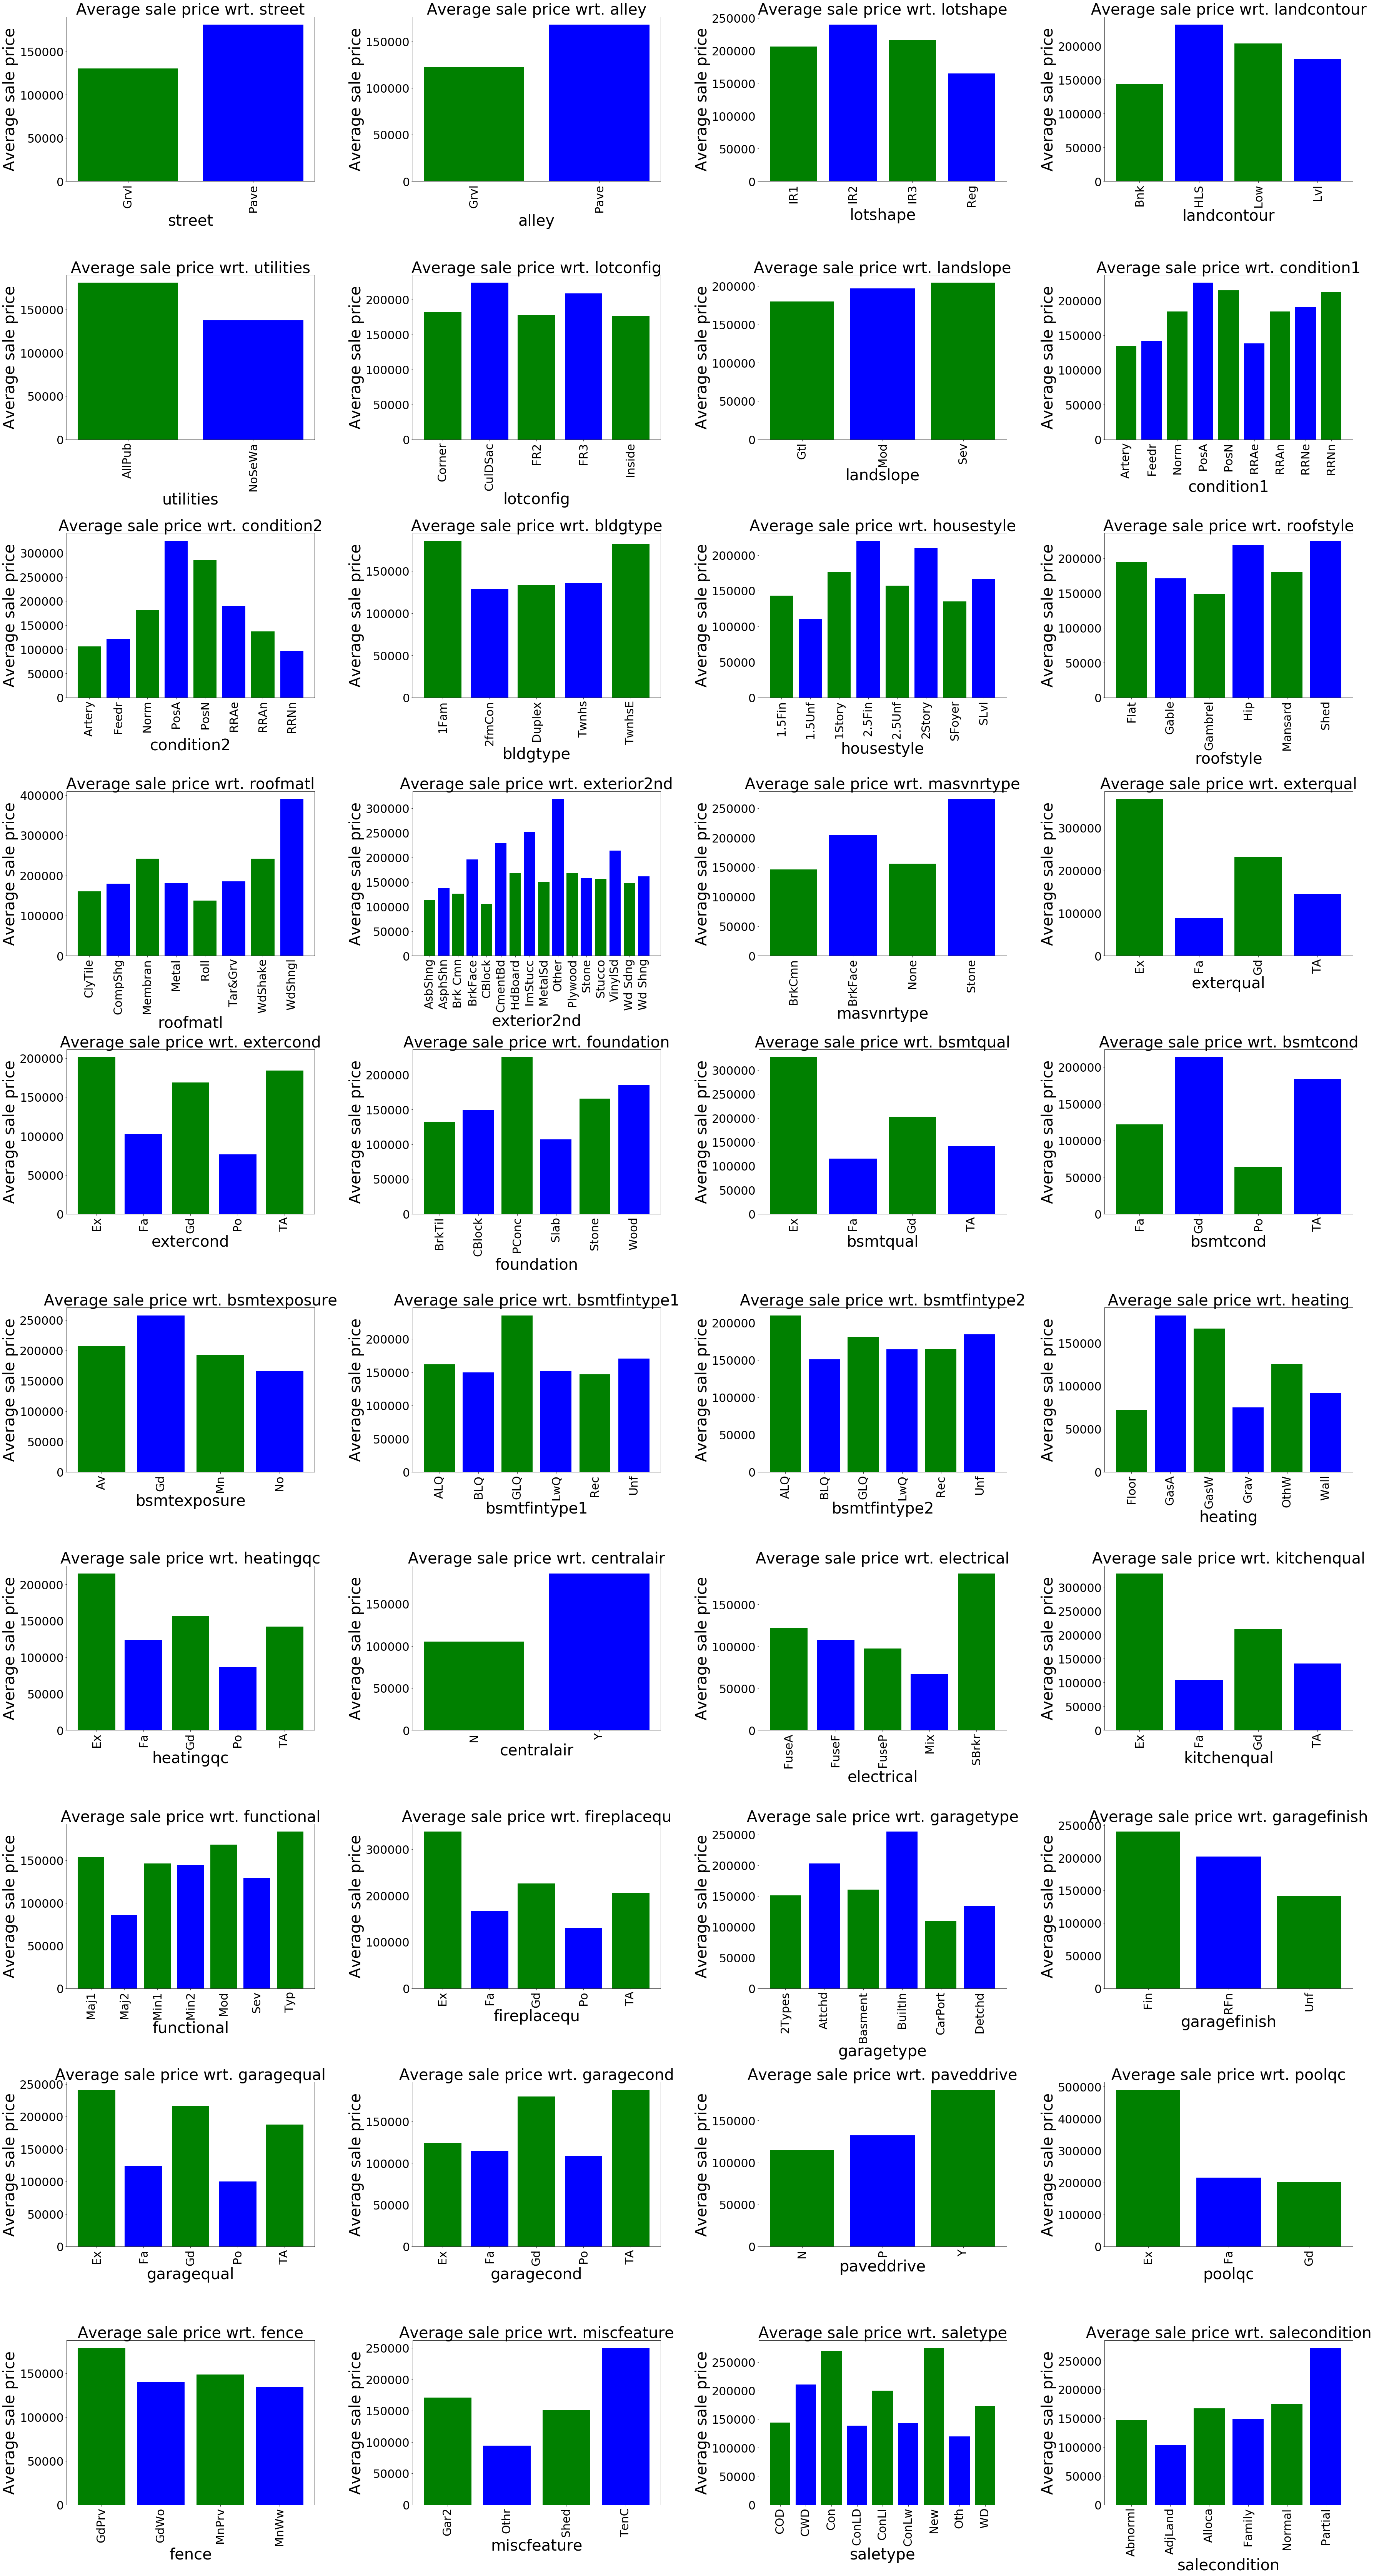

In [9]:
# bar chart relationship between target variable and alpha features
plt.figure(figsize=(50,100))

for index, column in enumerate(alpha_col):
    plt.subplot(11,4,index+1)
    plt.bar(df.groupby(column)["saleprice"].mean().index, df.groupby(column)["saleprice"].mean(), color=("green","blue"))
    plt.title("Average sale price wrt. {}".format(column), fontsize=40)
    plt.ylabel("Average sale price", fontsize=40)
    plt.xlabel(column, fontsize=40)
    plt.xticks(rotation='vertical')
    plt.tick_params(labelsize=30)

plt.tight_layout()
plt.show()

#### Observations  
- The above bar charts confirm the previous correlations

# Linear Regression Models

In [11]:
# define feature set
features = df[['overallqual', 
        'grlivarea', 
        'garagecars', 
        'int_over_sf', 
        'totalsf'
        ]]

# define target
target = np.log1p(df.saleprice)

Train observations: 1168
Test observations:  292


c:\users\ap\appdata\local\programs\python\python37-32\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


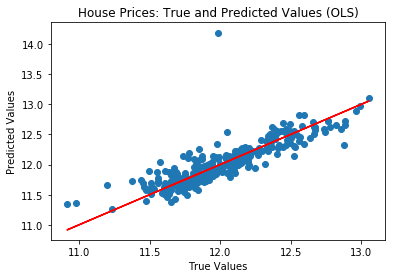

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     1056.
Date:                Sun, 08 Dec 2019   Prob (F-statistic):               0.00
Time:                        20:46:07   Log-Likelihood:                 389.04
No. Observations:                1168   AIC:                            -766.1
Df Residuals:                    1162   BIC:                            -735.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          10.3645      0.060    174.033      0.000      10.248      10.481
overallqual     0.1468      0.010     14.727      0.000       0.127       0.166
grlivarea     3.33e-05   2.04e-05      1.634      0.103   -6.69e-06    7.33e-05
garagecars      0.1055      0.009     11.744      0.000       0.088       0.123
int_over_sf  -1.12e-05   3.36e-06     -3.337      0.001   -1.78e-05   -4.62e-06
totalsf         0.0003   2.71e-05     10.268      0.000       0.000       0.000
==============================================================================
Omnibus:                      445.594   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3173.023
Skew:                          -1.585   Prob(JB):                         0.00
Kurtosis:                      10.426   Cond. No.                     2.21e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.21e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [12]:
# OLS

# define target and feature set
Y = target
X = features

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 3)

# print train/test shape
print('Train observations: {}'.format(X_train.shape[0]))
print('Test observations:  {}'.format(X_test.shape[0]))

# add constants
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# fit model
results = sm.OLS(y_train, X_train).fit()

# predict
y_preds = results.predict(X_test)

# scatterplot true vs predicted values
plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color='r')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('House Prices: True and Predicted Values (OLS)')
plt.show()

# summary results
results.summary()

#### Observations
- The model achieved an R-squared and adjusted R-squared accuracy score of 82%
- There is one strange outlier where the model predicted an extremely high house price, but the true value is much lower
- There are only three variables (overallqual, grlivarea, garagecars) with coefficient scores noticeably above zero. The p-values of these three variables are all zero, which indicates they are normally distributed.
- The rest of the variables had coefficient scores of zero, which means they have essentially no effect on the target variable. Or they had high p-values, which indicates their distributions are not normally distributed.
- However, when tinkering with the model I tried removing the underperforming features, but the model performed worse than the current iteration.
- We will keep all the current features for use in models

Train observations: 1168
Test observations:  292


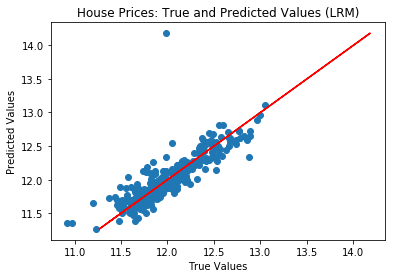

R-squared train set: 0.819645051600626

-----Test set statistics-----

R-squared test set:  0.6885885573522083
MAE:                 0.12655550136502142
MSE:                 0.040553327921671274
RMSE:                0.2013785686751976
MAPE:                1.0560491298556225



Coefficients: 
 [ 1.46760527e-01  3.33007060e-05  1.05528307e-01 -1.12023835e-05
  2.77923381e-04]

Intercept: 
 10.364452204256388


In [13]:
# linear regression

# define target and feature set
Y = target
X = features

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 3)

# print train and test shape
print('Train observations: {}'.format(X_train.shape[0]))
print('Test observations:  {}'.format(X_test.shape[0]))

# fit model
lrm = LinearRegression()
lrm.fit(X_train, y_train)

# predict
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

# scatterplot true vs predicted values
plt.scatter(y_test, y_preds_test)
plt.plot(y_preds_test, y_preds_test, color='r')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('House Prices: True and Predicted Values (LRM)')
plt.show()

# print summary statistics
print('R-squared train set: {}'.format(lrm.score(X_train, y_train)))
print("")
print('-----Test set statistics-----')
print("")
print('R-squared test set:  {}'.format(lrm.score(X_test, y_test)))
print('MAE:                 {}'.format(mean_absolute_error(y_test, y_preds_test)))
print('MSE:                 {}'.format(mse(y_test, y_preds_test)))
print('RMSE:                {}'.format(rmse(y_test, y_preds_test)))
print('MAPE:                {}'.format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

print("")
print("")

# print coefficients and intercept
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)

#### Observations
- Train set R-squared is 82%, same as the OLS model
- Again, that same outlier is present 
- Test set adjusted R-squared is 68.9%, underperforming the previous OLS model
- MAE, MSE, RMSE, and MAPE scores are all low

In [14]:
# lasso CV

# define target and feature set
Y = target
X = features

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

# print train and test shape
print('Train observations: {}'.format(X_train.shape[0]))
print('Test observations:  {}'.format(X_test.shape[0]))
print('')

# fit model
lasso_cv = LassoCV(alphas=alphas, cv=5)
lasso_cv.fit(X_train, y_train)

# predict
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

# print summary statistics
print('Best alpha value:    {}'.format(lasso_cv.alpha_))
print('R-squared train set: {}'.format(lasso_cv.score(X_train, y_train)))
print("")
print('-----Test set statistics-----')
print("")
print('R-squared test set:  {}'.format(lasso_cv.score(X_test, y_test)))
print('MAE:                 {}'.format(mean_absolute_error(y_test, y_preds_test)))
print('MSE:                 {}'.format(mse(y_test, y_preds_test)))
print('RMSE:                {}'.format(rmse(y_test, y_preds_test)))
print('MAPE:                {}'.format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

print("")
print("")

# print coefficients and intercept
print('\nCoefficients: \n', lasso_cv.coef_)
print('\nIntercept: \n', lasso_cv.intercept_)

Train observations: 1168
Test observations:  292

Best alpha value:    100
R-squared train set: 0.6541252776377666

-----Test set statistics-----

R-squared test set:  0.7730559215066828
MAE:                 0.14257142472924594
MSE:                 0.03646457898517961
RMSE:                0.1909570082117428
MAPE:                1.190066466230031



Coefficients: 
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.59546525e-05
 0.00000000e+00]

Intercept: 
 11.430823138794612


#### Observations
- Train set R-squared is 65.4%, the worst performing train set so far
- Test set adjusted R-squared increased to 77.3%, making it the second best performer behind OLS
- MAE, MSE, RMSE, and MAPE scores are again all low

In [ ]:
# ridge CV

# define target and feature set
Y = target
X = features

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

# print train and test shape
print("Train observations: {}".format(X_train.shape[0]))
print("Test observations:  {}".format(X_test.shape[0]))
print('')

# fit model
ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(X_train, y_train)

# predict
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

# print summary statistics
print('Best alpha value:    {}'.format(ridge_cv.alpha_))
print('R-squared train set: {}'.format(ridge_cv.score(X_train, y_train)))
print("")
print('-----Test set statistics-----')
print("")
print('R-squared test set:  {}'.format(ridge_cv.score(X_test, y_test)))
print('MAE:                 {}'.format(mean_absolute_error(y_test, y_preds_test)))
print('MSE:                 {}'.format(mse(y_test, y_preds_test)))
print('RMSE:                {}'.format(rmse(y_test, y_preds_test)))
print('MAPE:                {}'.format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

print("")
print("")

# print coefficients and intercept
print('\nCoefficients: \n', ridge_cv.coef_)
print('\nIntercept: \n', ridge_cv.intercept_)

#### Observations
- Train set R-squared is 80.4%, making it a middle-of-the-pack performer for train set
- Test set adjusted R-squared is 79.8%, making the second best performer behind OLS
- MAE, MSE, RMSE, and MAPE scores are again all low

In [ ]:
# elasticnet CV

# define target and feature set
Y = target
X = features

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

# print train and test shape
print("Train observations: {}".format(X_train.shape[0]))
print("Test observations:  d{}".format(X_test.shape[0]))
print('')

# fit model
elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5)
elasticnet_cv.fit(X_train, y_train)

# predict
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

# print summary statistics
print('Best alpha value:    {}'.format(elasticnet_cv.alpha_))
print('R-squared train set: {}'.format(elasticnet_cv.score(X_train, y_train)))
print("")
print('            ----- Test set statistics -----')
print("")
print('R-squared test set:  {}'.format(elasticnet_cv.score(X_test, y_test)))
print('MAE:                 {}'.format(mean_absolute_error(y_test, y_preds_test)))
print('MSE:                 {}'.format(mse(y_test, y_preds_test)))
print('RMSE:                {}'.format(rmse(y_test, y_preds_test)))
print('MAPE:                {}'.format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

print("")
print("")

# print coefficients and intercept
print('\nCoefficients: \n', elasticnet_cv.coef_)
print('\nIntercept: \n', elasticnet_cv.intercept_)

#### Observations
- Train set R-squared is 65.5%
- Test set adjusted R-squared is 77.6%, making it a mediocre performer
- MAE, MSE, RMSE, and MAPE scores are all low

## Summary Results
- Top performers
    > - OLS  
        > ~ Train:   82.1 %  
        > ~ Test:    81.9 %  
        > ~ Most accurate train and test score, best performer of all
        
    > - Ridge CV  
        > ~ Train:   80.51 %  
        > ~ Test:    79.81 %  
        > ~ Close 2nd place behind OLS
        
- Bottom performers
    > - Linear Regression  
        > ~ Train:   82.05 %  
        > ~ Test:    68.45 %  
        > ~ Inline with OLS and Ridge train scores, but test accuracy dropped significantly  
        > ~ Suggests overfitting
        
    > - Lasso CV  
        > ~ Train:   65.41 %  
        > ~ Test:    77.31 %  
        > ~ Better test score than train score surprisingly, but both accuracies on the low side
        
    > - Elasticnet CV  
        > ~ Train:   65.48 %  
        > ~ Test:    77.6 %  
        > ~ Similar to lasso, better test score than train score, but both accuracies on the low side

# Add Interest Rate and Unemployment Variables

In [15]:
# import dataset
df_int_rate = pd.read_csv(r'C:\Users\AP\Desktop\fed_interest_rates.csv')

In [16]:
# basic size and shape of dataset
df_int_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 904 entries, 0 to 903
Data columns (total 10 columns):
Year                            904 non-null int64
Month                           904 non-null int64
Day                             904 non-null int64
Federal Funds Target Rate       462 non-null float64
Federal Funds Upper Target      103 non-null float64
Federal Funds Lower Target      103 non-null float64
Effective Federal Funds Rate    752 non-null float64
Real GDP (Percent Change)       250 non-null float64
Unemployment Rate               752 non-null float64
Inflation Rate                  710 non-null float64
dtypes: float64(7), int64(3)
memory usage: 70.7 KB


In [17]:
# trim data to match same years as housing data, 2006-2010
df_int_rate = df_int_rate.loc[df_int_rate.Year.isin(['2006','2007', '2008', '2009', '2010'])]

In [18]:
# change all columns to lower case
df_int_rate.columns = map(str.lower, df_int_rate.columns)

In [19]:
# rename columns to match housing data columns before merge
df_int_rate = df_int_rate.rename(columns={"month": "mosold", "year": "yrsold"})

In [20]:
# reorder columns by similarity
df_int_rate = df_int_rate[['yrsold', 'mosold', 'day', 'effective federal funds rate', 'real gdp (percent change)', 'unemployment rate', 'inflation rate']]

In [21]:
# drop nulls
df_int_rate.dropna(inplace=True)

In [22]:
# quantify missing data
total_missing = df_int_rate.isnull().sum().sort_values(ascending=False)
percent_missing = (df_int_rate.isnull().sum()/df_int_rate.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Count', 'Percent'])

missing_data.head()

,Count,Percent
inflation rate,0,0.0
unemployment rate,0,0.0
real gdp (percent change),0,0.0
effective federal funds rate,0,0.0
day,0,0.0


In [23]:
# sample view of dataset
df_int_rate.head()

,yrsold,mosold,day,effective federal funds rate,real gdp (percent change),unemployment rate,inflation rate
752,2006,1,1,4.29,4.9,4.7,2.1
757,2006,4,1,4.79,1.2,4.7,2.3
762,2006,7,1,5.24,0.4,4.7,2.7
765,2006,10,1,5.25,3.2,4.4,2.7
768,2007,1,1,5.25,0.2,4.6,2.7


In [24]:
# combine original housing dataset with new federal reserve dataset
df_combine = pd.merge(df, df_int_rate, on=['yrsold', 'mosold'])

In [25]:
# check to make sure datasets were merged
df_combine.columns

Index(['id', 'mssubclass', 'mszoning', 'lotfrontage', 'lotarea', 'street',
       'alley', 'lotshape', 'landcontour', 'utilities', 'lotconfig',
       'landslope', 'neighborhood', 'condition1', 'condition2', 'bldgtype',
       'housestyle', 'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd',
       'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype',
       'masvnrarea', 'exterqual', 'extercond', 'foundation', 'bsmtqual',
       'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfinsf1',
       'bsmtfintype2', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'heating',
       'heatingqc', 'centralair', 'electrical', '1stflrsf', '2ndflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'kitchenqual',
       'totrmsabvgrd', 'functional', 'fireplaces', 'fireplacequ', 'garagetype',
       'garageyrblt', 'garagefinish', 'garagecars', 'garagearea', 'garagequal',
       'garagecond', 'paveddrive

In [26]:
# define new feature set adding fed funds rate and unemployment rate to original feature set
features_new = df_combine[['overallqual', 
        'grlivarea', 
        'garagecars', 
        'int_over_sf', 
        'totalsf',
        'effective federal funds rate',
        'unemployment rate'
        ]]

# target variable unchanged from previous models
target = np.log1p(df_combine.saleprice)

Train observations: 417
Test observations:  105


c:\users\ap\appdata\local\programs\python\python37-32\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


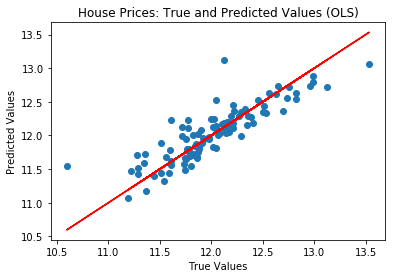

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     279.9
Date:                Sun, 08 Dec 2019   Prob (F-statistic):          1.47e-141
Time:                        20:52:10   Log-Likelihood:                 116.88
No. Observations:                 417   AIC:                            -219.8
Df Residuals:                     410   BIC:                            -191.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           10.0890      0.085    118.039      0.000       9.921      10.257
overallqual                      0.1962      0.014     14.341      0.000       0.169       0.223
grlivarea                        0.0001   3.57e-05      3.296      0.001    4.75e-05       0.000
garagecars                       0.1426      0.017      8.637      0.000       0.110       0.175
int_over_sf                  -2.955e-05   4.58e-06     -6.451      0.000   -3.85e-05   -2.05e-05
totalsf                          0.0003   4.41e-05      6.885      0.000       0.000       0.000
effective federal funds rate     0.0049      0.004      1.226      0.221      -0.003       0.013
==============================================================================
Omnibus:                      103.778   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              429.907
Skew:                          -1.032   Prob(JB):                     4.43e-94
Kurtosis:                       7.526   Cond. No.                     1.84e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.84e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [27]:
# OLS with added feature variable interest rate

# target variable(log-transformed) and feature set
Y = target
X = features_new.drop(['unemployment rate'], axis=1)

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 3)

# print train/test shape
print('Train observations: {}'.format(X_train.shape[0]))
print('Test observations:  {}'.format(X_test.shape[0]))

# add constants
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# fit model
results = sm.OLS(y_train, X_train).fit()

# predict
y_preds = results.predict(X_test)

# scatterplot true vs predicted values
plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color='r')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('House Prices: True and Predicted Values (OLS)')
plt.show()

# summary results
results.summary()

Train observations: 417
Test observations:  105


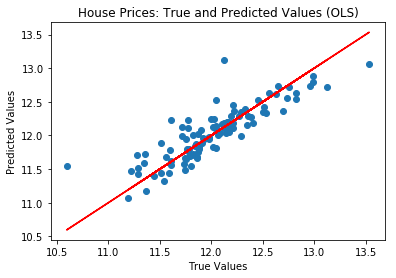

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     239.3
Date:                Sun, 08 Dec 2019   Prob (F-statistic):          2.56e-140
Time:                        20:52:31   Log-Likelihood:                 116.88
No. Observations:                 417   AIC:                            -217.8
Df Residuals:                     409   BIC:                            -185.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           10.0884      0.123     81.990      0.000       9.847      10.330
overallqual                      0.1962      0.014     14.312      0.000       0.169       0.223
grlivarea                        0.0001   3.58e-05      3.285      0.001    4.72e-05       0.000
garagecars                       0.1426      0.017      8.619      0.000       0.110       0.175
int_over_sf                  -2.954e-05   4.59e-06     -6.438      0.000   -3.86e-05   -2.05e-05
totalsf                          0.0003   4.42e-05      6.872      0.000       0.000       0.000
effective federal funds rate     0.0050      0.010      0.505      0.614      -0.015       0.025
unemployment rate             6.565e-05      0.010      0.007      0.995      -0.020       0.020
==============================================================================
Omnibus:                      103.782   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              429.886
Skew:                          -1.032   Prob(JB):                     4.48e-94
Kurtosis:                       7.526   Cond. No.                     2.64e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.64e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [28]:
# OLS with added new feature variable fed funds rate and unemployment rate

# target variable(log-transformed) and feature set
Y = target
X = features_new

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 3)

# print train/test shape
print('Train observations: {}'.format(X_train.shape[0]))
print('Test observations:  {}'.format(X_test.shape[0]))

# add constants
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# fit model
results = sm.OLS(y_train, X_train).fit()

# predict
y_preds = results.predict(X_test)

# scatterplot true vs predicted values
plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color='r')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('House Prices: True and Predicted Values (OLS)')
plt.show()

# summary results
results.summary()

In [29]:
# ridge CV with added feature variable fed funds rate

# target variable(log-transformed) and feature set
Y = target
X = features_new.drop(['unemployment rate'], axis=1)

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

# print train and test shape
print("Train observations: {}".format(X_train.shape[0]))
print("Test observations:  {}".format(X_test.shape[0]))
print('')

# fit model
ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(X_train, y_train)

# predict
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

# print summary statistics
print('Best alpha value:    {}'.format(ridge_cv.alpha_))
print('R-squared train set: {}'.format(ridge_cv.score(X_train, y_train)))
print("")
print('-----Test set statistics-----')
print("")
print('R-squared test set:  {}'.format(ridge_cv.score(X_test, y_test)))
print('MAE:                 {}'.format(mean_absolute_error(y_test, y_preds_test)))
print('MSE:                 {}'.format(mse(y_test, y_preds_test)))
print('RMSE:                {}'.format(rmse(y_test, y_preds_test)))
print('MAPE:                {}'.format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

print("")
print("")

# print coefficients and intercept
print('\nCoefficients: \n', ridge_cv.coef_)
print('\nIntercept: \n', ridge_cv.intercept_)

Train observations: 417
Test observations:  105

Best alpha value:    1
R-squared train set: 0.7975895756730897

-----Test set statistics-----

R-squared test set:  0.7329902802175373
MAE:                 0.13249138004252672
MSE:                 0.0376535197914799
RMSE:                0.19404514884809643
MAPE:                1.1114223278409627



Coefficients: 
 [ 1.90108657e-01  1.19688065e-04  1.39010622e-01 -2.51589487e-05
  2.71463744e-04  2.94401232e-03]

Intercept: 
 10.143928019504585


c:\users\ap\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [30]:
# ridge CV with added feature variables fed funds rate and unemployment rate

# target variable(log-transformed) and feature set
Y = target
X = features_new

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

# print train and test shape
print("Train observations: {}".format(X_train.shape[0]))
print("Test observations:  {}".format(X_test.shape[0]))
print('')

# fit model
ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(X_train, y_train)

# predict
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

# print summary statistics
print('Best alpha value:    {}'.format(ridge_cv.alpha_))
print('R-squared train set: {}'.format(ridge_cv.score(X_train, y_train)))
print("")
print('-----Test set statistics-----')
print("")
print('R-squared test set:  {}'.format(ridge_cv.score(X_test, y_test)))
print('MAE:                 {}'.format(mean_absolute_error(y_test, y_preds_test)))
print('MSE:                 {}'.format(mse(y_test, y_preds_test)))
print('RMSE:                {}'.format(rmse(y_test, y_preds_test)))
print('MAPE:                {}'.format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

print("")
print("")

# print coefficients and intercept
print('\nCoefficients: \n', ridge_cv.coef_)
print('\nIntercept: \n', ridge_cv.intercept_)

Train observations: 417
Test observations:  105

Best alpha value:    1
R-squared train set: 0.7983031722742714

-----Test set statistics-----

R-squared test set:  0.7291823126061721
MAE:                 0.13471708976888205
MSE:                 0.03819051666161883
RMSE:                0.19542394086093656
MAPE:                1.130591764381613



Coefficients: 
 [ 1.90673975e-01  1.19142812e-04  1.38311850e-01 -2.49186248e-05
  2.68357235e-04  1.49271187e-02  1.32665903e-02]

Intercept: 
 10.026709863123735


c:\users\ap\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## New Summary Results  
__OLS__
- Original OLS model (%)  
    > Train: 82.1   
    > Test:  81.9
    
- OLS model with added variable fed funds rate (%)  
    > Train: 80.4  
    > Test: 80.1

- OLS model wtih added variables fed funds rate and unemployment rate (%) 
    > Train: 80.4  
    > Test:  80
    
    
__RIDGE CV__  
- Original Ridge CV model (%)  
    > Train: 80.5  
    > Test:  79.8

- Ridge CV model with added variable fed funds rate (%)  
    > Train: 79.7  
    > Test:  73.3

- Ridge CV model wtih added variables fed funds rate and unemployment rate (%)  
    > Train: 79.8  
    > Test:  72.9  
    
-------------------------------------------------------------------------------------------

First, the new dataset from the Federal Reserve was loaded and merged with the original housing dataset. Next, I chose to rerun OLS and Ridge CV because they were the best performing models from the previous runs. I then ran each model two more times, for a total of three times for each model. Once with the original housing data, once with the original data plus an added variable (federal funds rate), and once with the original data plus two added variables (federal funds rate and unemployment rate).  

The best performing model overall was the OLS model on the original data with no added variables. The added variables from the Federal Reserve, whether one or both variables, performed weaker than the models on the original data by itself.  

It seems reasonable and logical that variables like the federal funds rate and unemployment rate would have an effect on predicting house prices. The federal funds rate is the interest rate at which banks lend to each other, which could directly affect mortgage rates, which in turn affects housing prices. 

The unemployment rate also seems like it should have an effect on predicting house prices. A very low unemployment rate implies many Americans have the money to buy homes, affecting supply and demand of houses, which in turn affects house prices. Supply and demand for houses would just as well be affected by a very high unemployment rate.  

The data so far shows that these two new variables do not have a positive linear effect on the accuracy scores of predicting house prices, but this seems like it should not be the case. It is possible that with different feature arrangements or feature engineering the prediction accuracy scores would increase significantly, including the two new variables from the Federal Reserve. 